# Stay In Your Lane!
## Automated Bike Lane Enforcement With Neural Network Image Classification: Technical Notebook
### Author: Jesse Markowitz, October 2021

| <img src="readme_images/cab_in_bikelane.png" alt="yet another cab in a bike lane" width="600"/> | 
|:--:| 
| *A scene often seen in NYC* |

In [1]:
# Load dependencies
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from pickle import load

from functions import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Delete metadata files created by Mac OS
!find . -name ".DS_Store" -delete

## Business Understanding

Biking is my primary mode of transportation in and around New York City, as it is for an increasing number of people every year. I bike to commute to work, for groceries or other personal trips, and for exercise/pleasure. However, on every single trip I make in the city, I face a serious safety issue: **cars parked in bike lanes force me to weave in and out of traffic.** Although it is illegal to stop, stand, or park in a bike lane, vehicles in the city frequently do. Despite an increase in bike infrastructure and ridership in NYC, this problem continues, seemingly unenforced. It is possible to report offenders via 311 and the [Reported app](https://reportedly.weebly.com/) makes this especially easy. In general though, only Taxi and Limousine Commission (T&LC) drivers (yellow and green cabs, as well as rideshare vehicles for Uber, Lyft, etc.) are held accountable for these violations, as there is a set of prosecutors specifically for that regulatory purpose. When it comes to delivery trucks, personal cars, and police vehicles, 311 simply forwards the complaint to the local police precinct, where it is up to the responding officer's discretion to follow up. This rarely occurs. **Insufficient enforcement of bike lane traffic laws creates serious safety issues for cyclists.**

<img src="readme_images/blocked_bike_lane_nj_port_authority.png" alt="yet another cop in the bike lane" width="600"/>

On September 15, 2021, the NYC DOT released a ["Request for Expressions of Interest"](https://a856-cityrecord.nyc.gov/RequestDetail/20210907107) to create a system for automated bike lane enforcement. A system for bus lanes called the Automated Bus Lane Enforcement (ABLE) system was created by [Siemens Mobility](https://www.mobility.siemens.com/us/en/company/newsroom/short-news/first-ever-mobile-bus-lane-enforcement-solution-in-new-york.html) and installed in 2010 and has been expanded since then with great success, as measured by increased route speed and ridership. Automating enforcement of bike lane traffic laws could increase enforcement from what seem to be negligible levels while reducing the need for active police involvement, improving safety for the city's cyclists.

The goal of this project is to take a necessary step toward automating enforcement by building and training a model to identify when a car is parked in a bike lane. The scope of this project is limited to images that are guaranteed to contain a bike lane, based on the idea of an automated enforcement system comprised of stationary cameras placed on streets with bike lanes. The cameras would point up or down the street in order to monitor as much of the length of the bike lane as possible.

Models are evaluated using accuracy and precision (the true-positive rate), as well as an inspection of model decision-making using the [Lime](https://github.com/marcotcr/lime) package. Precision is used to ensure that false-positives are kept to a minimum. 

## Data Understanding and Preparation

This project required the assembly and processing of an entirely new dataset. The dataset consists of just over 1,800 images of New York City bike lanes, up from about 1,600 at the beginning of the project. Just over half of these images are of a bike lane obstructed by a vehicle, which comprises the target class. The rest of the images are of bike lanes without vehicular obstruction, showing entirely empty bike lanes or, on occassion, bike lanes with cyclists or pedestrians. The small size of the dataset is one of the most significant limitations of this project.

The images in the dataset were collected from a variety of sources:
 - The [Reported app's Twitter page](https://twitter.com/Reported_NYC), which tweets all traffic violations reported through the app
 - A large dataset of images provided by [Ryan Gravener](https://github.com/snooplsm), who is working on an image recognition project for Reported
 - Screenshots from Google Maps Street View
 - Manual collection (i.e., taking photos while biking around the city--this is the source of the vast majority of the non-target images of unobstructed bike lanes)

### Preprocessing

#### Re-orienting images
All of the images collected manually were taken with an iPhone X and saved as jpegs. Modern digital cameras and smartphone cameras attach an Orientation tag to the EXIF data with each photo taken to ensure that they are displayed correctly. This allows the photograph to orient the camera as they need to and ensures that the photo will be displayed correctly:

![image orientation tags](readme_images/orient_flag2.png)
[(source)](https://jdhao.github.io/2019/07/31/image_rotation_exif_info/)

This tag is read by most image display programs in order to orient the image correctly without altering the underlying image data, but a Keras `ImageDataGenerator` does not do this. As a result, images collected manually may be improperly oriented when fed into the model and may be turned by 90° or 180°:

![unoriented images](readme_images/unoriented_images.png)

To solve this issue, the `exif_transpose` method from `PIL.ImageOps` was used in a custom `reorient_images` function to create a correctly oriented copy of every image in the dataset. This results in a dataset of correctly oriented images, as demonstrated below:

In [3]:
# Read files in as images
# Directories
train_dir = 'input_images/full_combined'
train_open_dir = os.path.join(train_dir, 'open_bike_lane')
train_vehicle_dir = os.path.join(train_dir, 'vehicle_bike_lane')

oriented_open_images = get_images(train_open_dir, num_images=5)

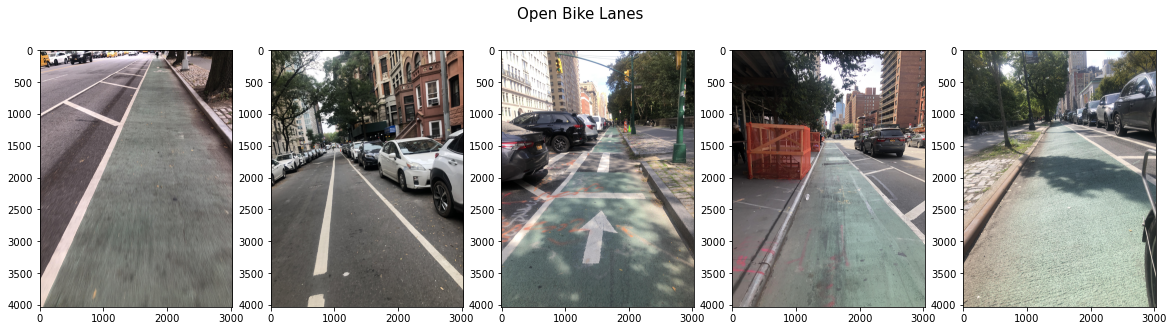

In [4]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(oriented_open_images[i])
fig.suptitle('Open Bike Lanes', fontsize=15)
fig.tight_layout;

The `reorient_images` function was applied to all images in the dataset in order to save a new, reoriented copy of every image. The original images were then discarded. More details and code about this issue can be found in the [EDA notebook](code/EDA.ipynb); the `reorient_images` function is found in [`functions.py`](functions.py).

#### Cropping images
Many of the images collected via Reported contain a timestamp printed at the top of the image, which enhances the photo's value as evidence in a potential case.

In [5]:
# Read files in as images
uncropped_dir = 'other_images/imgs_to_crop'
uncropped_vehicle_dir = os.path.join(uncropped_dir, 'vehicle')

uncropped_vehicle_images = get_images(uncropped_vehicle_dir, num_images=5)

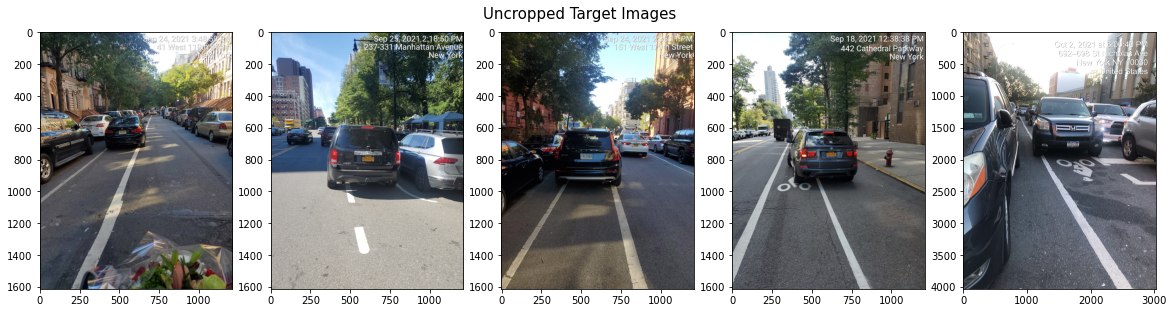

In [6]:
# Display uncropped images
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(uncropped_vehicle_images[i])
fig.suptitle('Uncropped Target Images', fontsize=15, y=0.93)
fig.tight_layout;

However, this creates potential data leakage and a possible confounding feature in the dataset because images with timestamps will be overrepresented in the target class. Without removing this feature, it's possible that the model will use it to predict the target class, rather than attending to real features in the image.

Cropping the top 175 pixels of the image is an easy way to remove the entire timestamp for most images, while preserving the important features of the image:

In [7]:
# List of filenames
vehicle_filenames = os.listdir(uncropped_vehicle_dir)

# Crop the images
cropped_vehicle_images = [crop_image(uncropped_vehicle_dir, name) for name in vehicle_filenames]

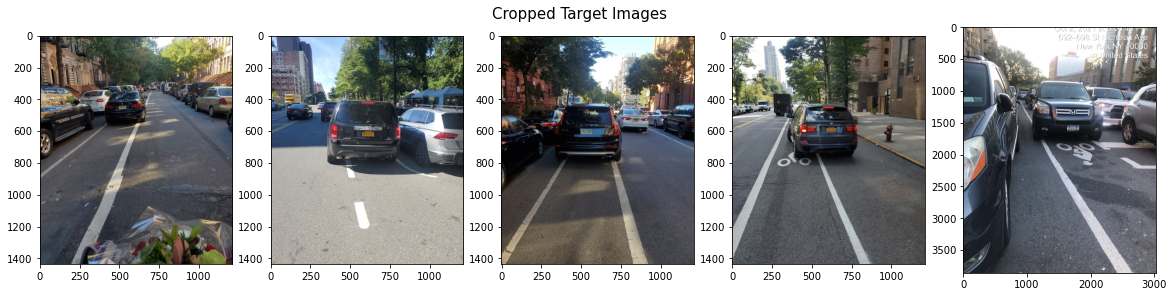

In [8]:
# Display results
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(cropped_vehicle_images[i])
fig.suptitle('Cropped Target Images', fontsize=15, y=0.9)
fig.tight_layout;

Notice how the final image to the right still contains some timestamp. Although cropping out the top 175 rows of pixels from an image was sufficient for most images, it is still necessary to visually inspect the results and manually crop more if necessary. (More details and code can be found in the [crop_timestamp](code/crop_timestamp.ipynb) notebook.)

#### Removing unclear images
The final step before a train-val-test split is to manually review images, ensuring they are in the correct class directory, and removing any that are inappropriate or unclean. Images were generally removed that:
 - did not show both lane lines of a bike lane (lines too faint or photo taken too "close up" to a vehicle)
 - showed a bike lane from the side (photo was taken from across the street, facing across the street or toward the sidewalk)
 - contained too many cyclists, motorbikes, or pedestrians such that the bike lane was significantly obstructed
 - were taken at night (these were extremely overrepresented in the target class)
 - showed a car in a bike lane legally (i.e., crossing an intersection) or parked in a legally ambiguous zone (i.e., lane lines dashed or too faded to see)e
 - were unclear (such as showing a potential vehicular obstruction too far in the distance to tell for sure)

The following are a small set of representative examples of the over 200 images that were ultimately removed from the orginal dataset:

![examples of unused images](readme_images/examples_unused.png)

Some images that were unclear were cropped in order to keep them in the dataset. For instance, an image like the one to the far right could be cropped in order to show the open bike lane, removing the possible vehicular obstruction entirely and placing the image in the non-target class folder. This manual operation was performed on several images in order to avoid removing data from the already small dataset.

Many of these decisions were subjective judgments and there were a surprisingly large number of images that were ambiguous. These images were kept in a separate `unused_images` folder for transparency and possible later inclusion or testing. 

Because the dataset is also limited, it was thought best to restrict the data to only the clearest examples that match the intended use with an automated enforcement system and scope of the project. The hope is that with more data and continued model training, a model can be created that also recognizes pedestrians or cyclists as well.

### Train-Validation-Test Split

Only 100 images (50 of each class) were set aside as a testing/holdout set for final model evaluation in order to maximize the training set. An additional 100 images (50 of each class) were later set aside as a `validation` set. The [split-folders](https://pypi.org/project/split-folders/) package provides an easy way to accomplish this and has methods for splitting either by a ratio or a fixed number. 

My initial split to create the testing/holdout set was as follows:
```python
# Split off test set
splitfolders.fixed("other_images/processed_images", 
                   output="input_images", 
                   seed=42, 
                   fixed=(50))
```
I continued to collect more images throughout the beginning of the project to increase the size of the dataset. As new images were collected, they were added to a separate `new` folder, separate from the original `train` image set, then combined in a separate `full_combined` folder to be used for continued model training. 

I actually split twice because I did not start with a `validation` set, opting instead to use the `validation_split` parameter in Keras's `ImageDataGenerator` class. However, this causes two serious data issues. 

First, it creates a non-random validation set because `validation_split=0.1` simply withholds the last 10% of images in the ordered dataset. Since my images are arranged alphabetically and their names are determined by their source, that meant that some sets of images, such as Google Maps Street View screenshots, were being used exclusively for either training or validation. A non-random validation sample is not ideal.

The second issue with `validation_split` is that it still applies image augmentation to the validation set, meaning that the model is being validated on unrealistic data. (See below for more dicussion and examples of image augmentation.)

To solve both of these issues in one, I re-split my training data to create a separate `validation` folder to use with a separate `ImageDataGenerator` rather than by using `validation_split`:
```python
# Split off validation set
splitfolders.fixed("input_images/full_combined", 
                   output="input_images/validation", 
                   seed=42, 
                   fixed=(50))
```

This resulted in the following file structure for processed images:

```
└── input_images
    ├── full_combined
    ├── new
    ├── test
    ├── train
    └── validation
```
Each folder of images contains 2 subfolders to designate image classes, as shown below with one example:
```
└── input_images
    ├── full_combined
    │    ├──open_bike_lane
    │    └──vehicle_bike_lane
```

New images added after the project started were added to the `full_combined` folder as well as kept separately in the `new` folder (after processing) in order to facilitate experiments with continued model training. For instance, I compared final metrics for models that had been trained on the original `train` set, then continued training on either only new data or a combination of new and original data. I then compared those metrics to a model trained from scratch on the `full_combined` dataset. These experiments are located in the [CNN2](code/CNN2.ipynb) notebook under the "Training old models on new data" heading toward the end of the notebook.

### Class distribution

I ensured that both the `validation` and holdout `test` sets contained an even 50/50 split of image classes. Overall, there is a fairly balanced distribution of the classes in the full training image dataset.

In [9]:
# Check functionality and number of images
print('There are', len(os.listdir(train_open_dir)), 'non-target images in the training set')
print('There are', len(os.listdir(train_vehicle_dir)), 'target images in the training set')

# Expecting:
# 758 non-target
# 861 target

There are 758 non-target images in the training set
There are 861 target images in the training set


<ipython-input-10-aa3cbb8e6ffa>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(p*100))+'%' for p in ax.get_yticks()])


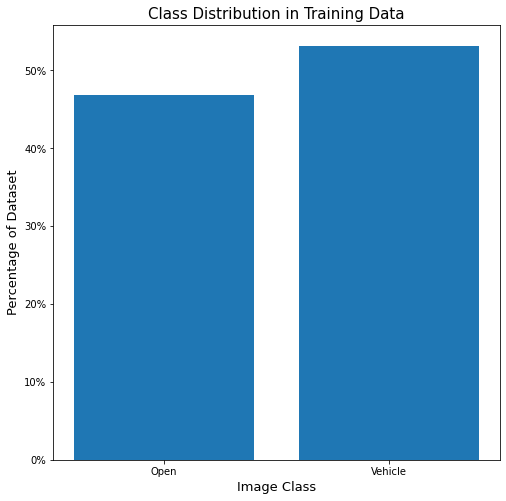

In [10]:
# Visualize class distribution in training data
num_open = len(os.listdir(train_open_dir))
num_vehicle = len(os.listdir(train_vehicle_dir))
total_images = num_open + num_vehicle
fig, ax = plt.subplots(figsize=(8, 8))

ax.bar(x=['Open', 'Vehicle'], height=[num_open/total_images, 
                                                  num_vehicle/total_images])
ax.set_title('Class Distribution in Training Data', size=15)
ax.set_ylabel('Percentage of Dataset', size=13)
ax.set_xlabel('Image Class', size=13)
ax.set_yticklabels([str(int(p*100))+'%' for p in ax.get_yticks()])
plt.show()

Although there are slightly more target class images, this imbalance was not considered large enough to be a serious issue.

### Image Samples

Below are samples of a few images from each class.

In [11]:
# Load images
open_images = get_images(train_open_dir, num_images=10)
vehicle_images = get_images(train_vehicle_dir, num_images=5)

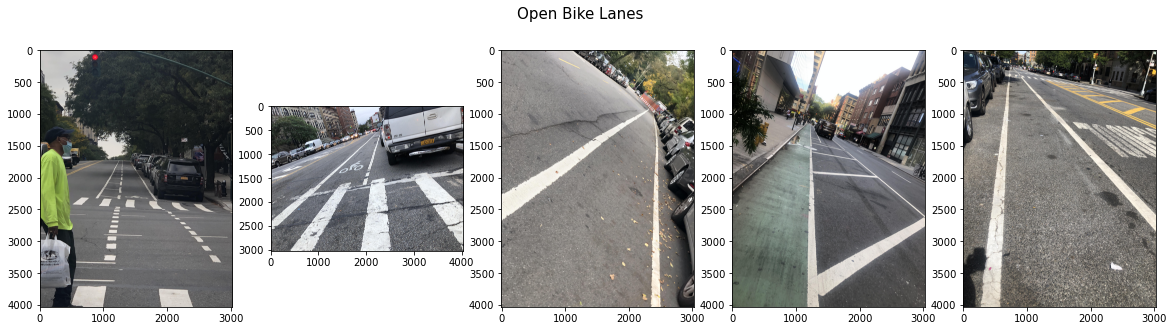

In [12]:
# Images of open bike lanes
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(open_images[i+5]) # See some new ones
fig.suptitle('Open Bike Lanes', fontsize=15)
fig.tight_layout;

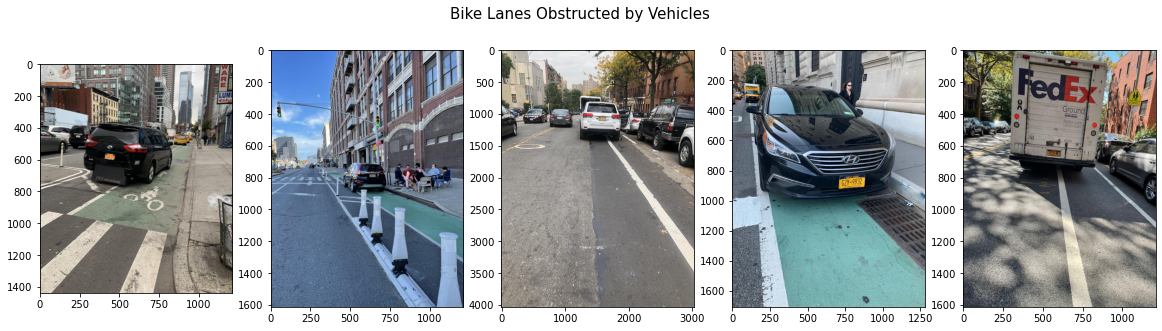

In [13]:
# Images of bike lanes obstructued by vehicles
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(vehicle_images[i])
fig.suptitle('Bike Lanes Obstructed by Vehicles', fontsize=15)
fig.tight_layout;

The hope is that a neural network, and especially the pattern-detecting filters in a convolutional neural network, will be able to detect the lane lines and vehicle shapes in the images. The images are so consistent in content and perspective and similar both within and between the classes except for the main feature (a vehicle in the bike lane). Because of this, it seems reasonable that a model can predict the classes with high accuracy, even with a small dataset.

With the data processed and arranged in an appropriate file structure, it's time to get modeling!

## Modeling with Neural Networks

The following models represent key benchmarks in a process of model iteration that resulted in over 20 models trained on the data. The full set of evaluation metrics from and notes on each model can be found in the [model_tracker](model_tracker.csv) spreadsheet.

### First Simple Model

The first simple model consists of a basic neural network with only 1 fully connected dense layer, plus an output layer. It was originally trained on the initial smaller dataset, before more images were added, without image augmentation or any non-default parameters aside from rescaling, and with `validation_split=0.2`. (The full code and training data for the First Simple Model can be found in the [FSM](code/FSM.ipynb) notebook.)

In [14]:
# Load model
fsm = models.load_model('models/fsm.h5')
# Load pickled training history
fsm_history = load(open('models/fsm_history.pkl', 'rb'))

fsm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                6291488   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 6,291,521
Trainable params: 6,291,521
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Image folder for training
train_dir = 'input_images/train'

# Get data from directories and scale
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(train_dir, subset='training', class_mode='binary')
val_gen = datagen.flow_from_directory(train_dir, subset='validation', class_mode='binary', shuffle=False)

Found 1089 images belonging to 2 classes.
Found 272 images belonging to 2 classes.


Training eval:
35/35 [==============================] - 117s 3s/step - loss: 0.4567 - acc: 0.7576 - recall: 0.7723 - precision: 0.7531

Validation eval:
9/9 [==============================] - 19s 2s/step - loss: 0.7816 - acc: 0.7096 - recall: 0.8905 - precision: 0.6559


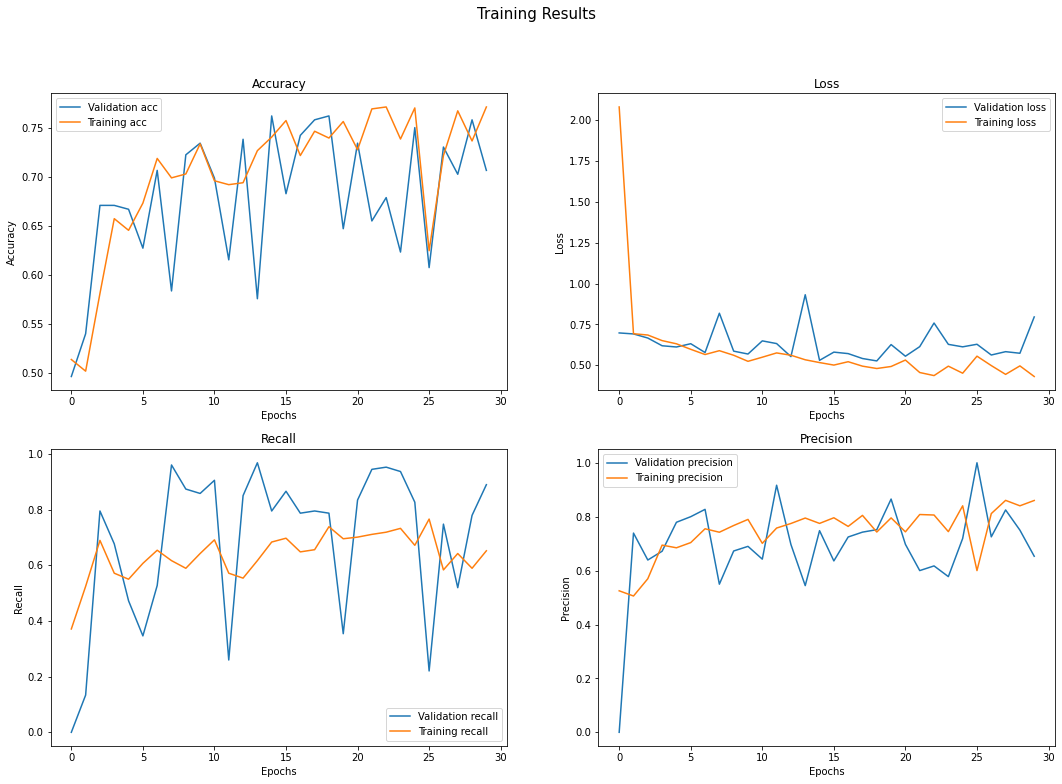

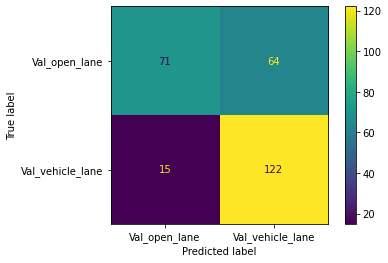

In [16]:
visualize_results(fsm_history, fsm, train_gen, val_gen)

To have all training and some validation metrics above 70% from the FSM was very heartening, especially with such a simple architecture. This model already shows promise at identifying the target class as well.

### Dense NN Iterations

The obvious next step to improve the model is to add more layers. The following model shows a deeper, more complex structure. It was trained on the same dataset as the FSM, with a 20% validation split. (The full code and training data for the fully connected dense NN models can be found in the [dense_NN](code/dense_NN.ipynb) notebook.)

In [17]:
# Load model
nn_model = models.load_model('models/nn_model_1.h5')
# Load pickled training history
nn_history = load(open('models/nn_model_1_history.pkl', 'rb'))

nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               100663808 
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 12)                396       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 13        
Total params: 100,699,129
Trainable params: 100,699,129
Non-trainable params: 0
__________________________________________

Training eval:
35/35 [==============================] - 114s 3s/step - loss: 0.4418 - acc: 0.7787 - recall_1: 0.6339 - precision_1: 0.8969

Validation eval:
9/9 [==============================] - 19s 2s/step - loss: 0.5293 - acc: 0.7316 - recall_1: 0.7153 - precision_1: 0.7424


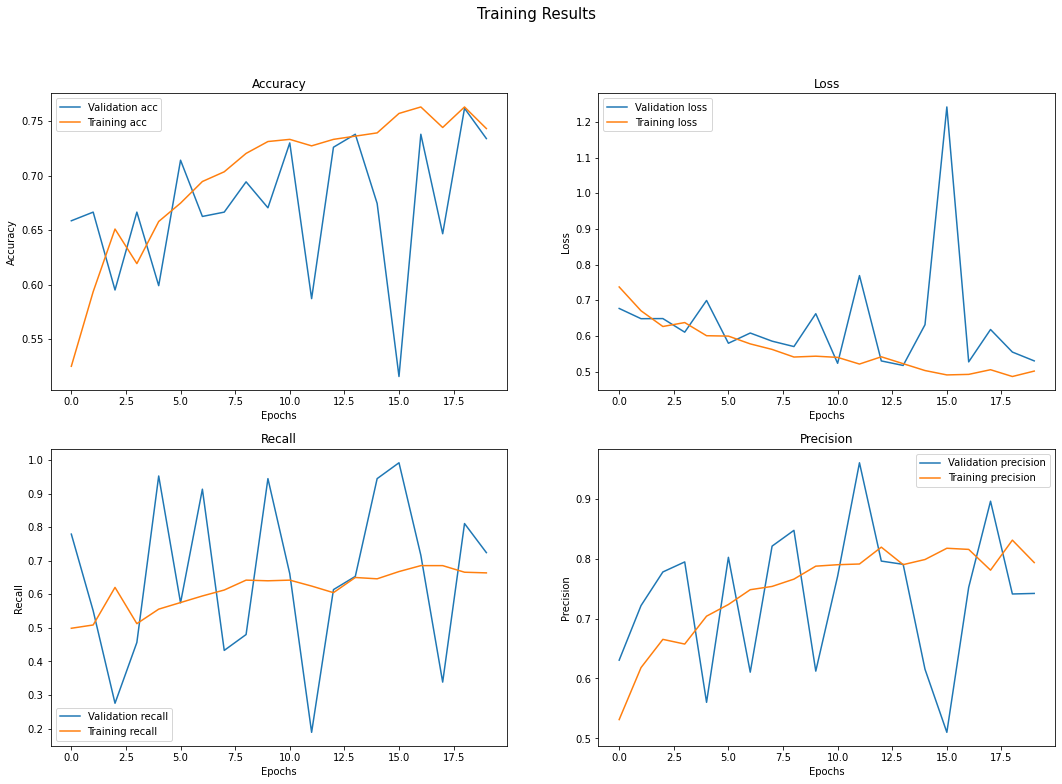

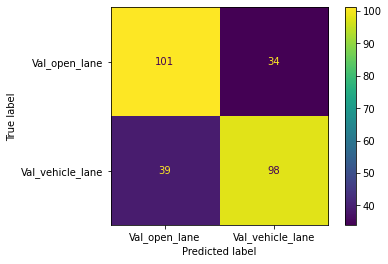

In [18]:
visualize_results(nn_history, nn_model, train_gen, val_gen)

Clearly, adding more layers is beneficial for balancing out the accuracy in terms of recall and precision, but ultimately the metrics still leave plenty of room for improvement.

Neural networks already have a propensity to overfit, let alone with a dataset as small as this one. Adding image augmentation to address both of these concerns only resulted in lower metrics with less consistency for models made only of fully connected dense layers. Further improvements could likely be made through the addition of convolutional layers.

### Convolutional Neural Networks

By adding convolutional layers, the hope is that the model will be able to identify specific patterns in the training images. Ideally, it will be able to recognize the bike lane and lane lines themselves, as well as the front or back end of a vehicle present in the image. My [initial CNN model](code/CNN1.ipynb) was incredibly adept at fitting itself to the training set--so much so that its training accuracy, recall, and precision were all at 100%, clearly overfitting the data. 

The main step taken to account for this issue, as well as to solve the issues around having a small dataset, is to introduce *image augmentation*. This technique involves altering the images that are fed into the model, often by mirroring or rotating them, zooming in or out, stretching them, or altering the brightness. The images below show the results of augmentation using the following parameters:
```python
ImageDataGenerator(rotation_range=30, 
                   horizontal_flip=True,
                   width_shift_range=.1, 
                   height_shift_range=.1,
                   brightness_range=[0.5, 1.5], 
                   zoom_range=.2)
```
![augmented images](readme_images/image_augmentation.png)

*(More exploration of image augmentation can be found in the [image_augmentation](code/image_augmentation.ipynb) notebook.)*

Image augmentation through the Keras `ImageDataGenerator` is performed randomly and on the fly. This allows the model to train on a variety of images beyond just those in the dataset. It's important to use parameters that the model is likely to see. I chose these parameters to account for images from either side of the street, in a variety of lighting conditions, spotting a variety of vehicles in the bike lane at a variety of distances from the camera and locations in the frame.

Several different models were evaluated with slightly different architectures, including adding BatchNormalization layers, using l2 regularization in the convlutional layers, and adding a Dropout layer to the final fully connected dense layers. The l2 regularization and Dropout layers were both successful at improving validations scores while reducing overfitting. The following model shows the structure of a model with l2 regularization. I also reduced the `validation_split` from 0.2 to 0.1 to give the model more images to learn on.

(The full code and training data for iterations on CNN models can be found in the [CNN1](code/CNN1.ipynb) and [CNN2](code/CNN2.ipynb) notebooks.)

In [19]:
# Get data from directories and scale
l2_datagen = ImageDataGenerator(rescale=1./255, 
                                validation_split=0.1,
                                horizontal_flip=True,
                                rotation_range=20, 
                                brightness_range=[0.5, 1.5], 
                                zoom_range=.2)

l2_train_gen = l2_datagen.flow_from_directory(train_dir, subset='training', class_mode='binary')
l2_val_gen = l2_datagen.flow_from_directory(train_dir, subset='validation', class_mode='binary', shuffle=False)

Found 1226 images belonging to 2 classes.
Found 135 images belonging to 2 classes.


In [20]:
# Load model
cnn_model = models.load_model('models/cnn_model_4.h5')
# Load pickled training history
cnn_history = load(open('models/cnn_history_4.pkl', 'rb'))

cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 128)      

Training eval:
39/39 [==============================] - 149s 4s/step - loss: 0.3288 - acc: 0.8760 - recall_2: 0.8026 - precision_2: 0.9430

Validation eval:
5/5 [==============================] - 9s 2s/step - loss: 0.2417 - acc: 0.9259 - recall_2: 0.8971 - precision_2: 0.9531


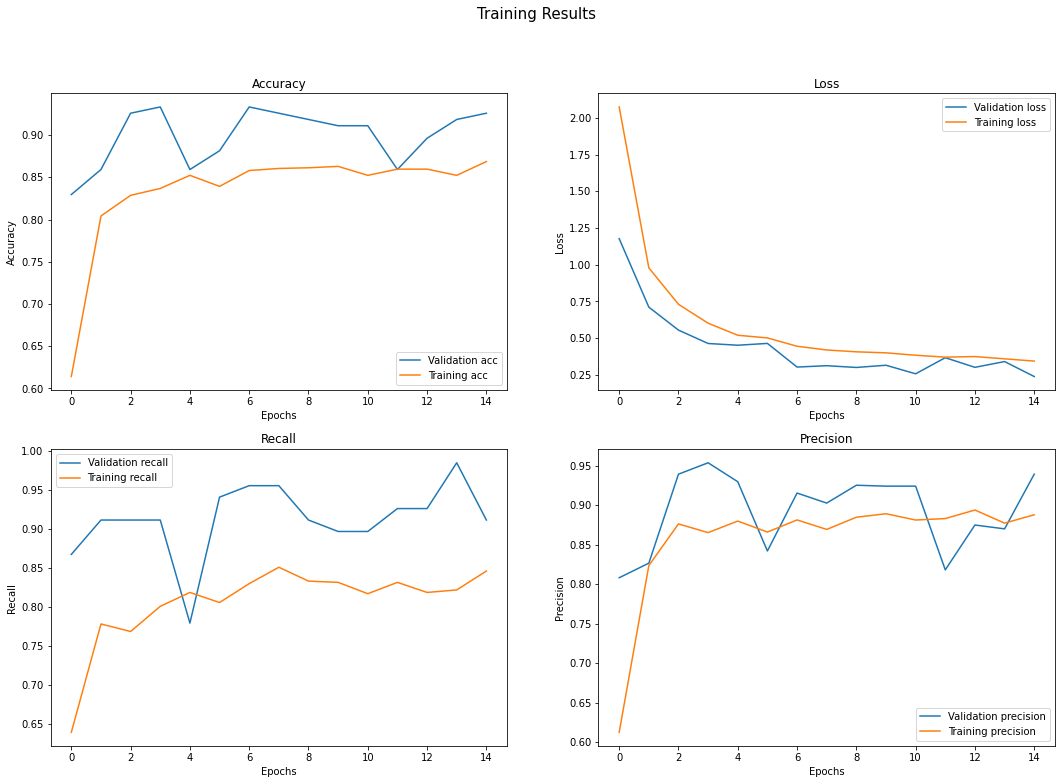

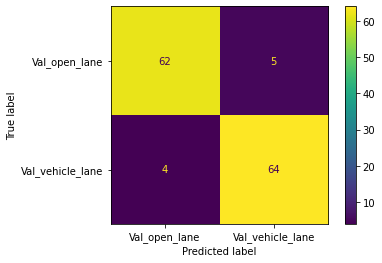

In [21]:
visualize_results(cnn_history, cnn_model, l2_train_gen, l2_val_gen)

This shows a definite improvement. However, with such a small validation set it's still difficult to fully trust the metrics. It's also important to get a sense of what the model is actually doing in order to ensure it's making its predictions and classification decisions based on features that are actually important in the image. 

### Visual inspection of model activity with `Lime`

The [Lime](https://github.com/marcotcr/lime) package provides tools to make black-box models interpretable. With Lime's `explaner` class, it's possible to get a sense of what the model is primarily attending to in the images and which features it's using to make its predictions.

Below are several examples of Lime in action, using one of the CNN models I trained. Lime performs small alterations on the data being fed into the prediction function of the model in order to determine which areas/features affect the model's prediction the most. Those areas/features are reported via colored masks overlaid on the images. Green areas signify those features that support the given prediction, while red areas represent votes for the opposite class.

In [22]:
datagen = ImageDataGenerator(rescale=1./255)
lime_gen = datagen.flow_from_directory('input_images/train', class_mode='binary', shuffle=True, batch_size=1)

Found 1361 images belonging to 2 classes.



Predicted class: [1.]
Actual class: 1.0


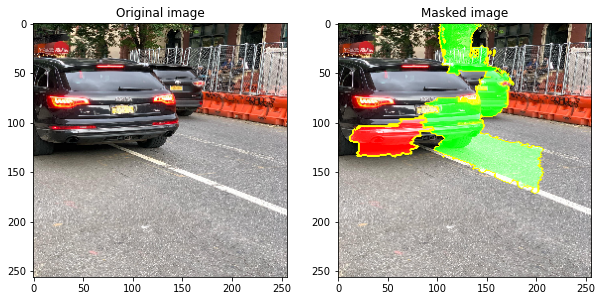

In [23]:
# Show one example
show_explanation(lime_gen, cnn_model)

Based on this image, it appears that the model is recognizing features exactly as hoped. It shows recognition of a vehicle, especially in the context of a bike lane, as the model focuses on where the vehicle meets the road and the space between the lane lines. It also appears to recognize the part of the vehicle outside of the bike lane as potential evidence for predicting the non-target class. 

Below are several more examples of Lime's interpretation of what this CNN model is doing.  



Predicted class: [1.]
Actual class: 1.0


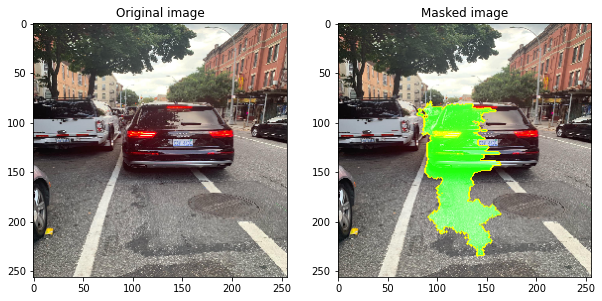


Predicted class: [0.]
Actual class: 0.0


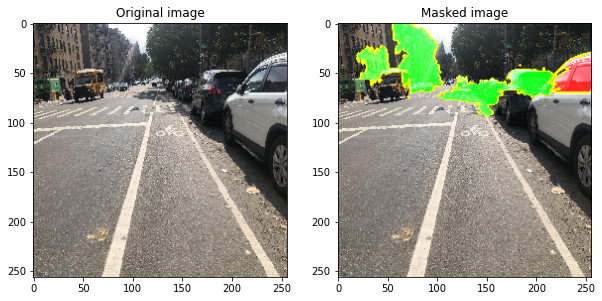


Predicted class: [1.]
Actual class: 1.0


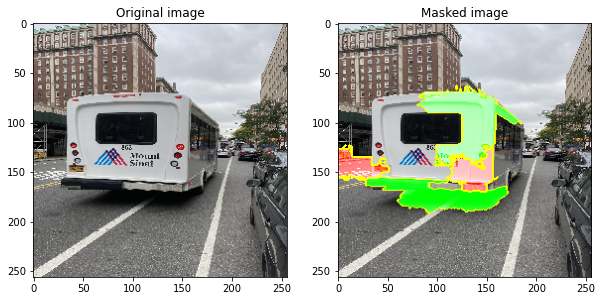


Predicted class: [1.]
Actual class: 1.0


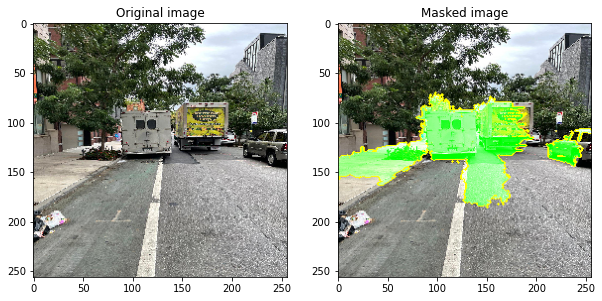


Predicted class: [1.]
Actual class: 1.0


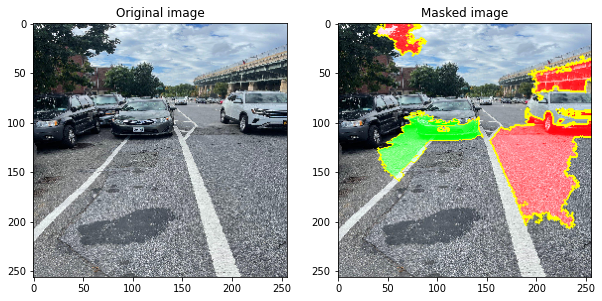

In [25]:
# Show several examples
for _ in range(5):
    show_explanation(lime_gen, cnn_model)

*(More explorations and examples with Lime can be found in the [Lime](code/Lime.ipynb) notebook, as well as in [CNN2](code/CNN2.ipynb).)*

Lime shows that the model is often sensitive to areas in which a vehicle and lane line meet in target class images, as this is often a good sign of bike lane obstruction (conventional bike lanes are narrower than a vehicle). In non-target images the model still predicts correctly the vast majority of the time, but Lime suggests that, as expected, it's difficult to identify when something is *not* in an image. Often the bike lane unobstructed to the horizon line provides a clear reason for predicting the non-target (`0`) class (open bike lane). The model appears to recognize the vehicles in the image as well, which sometimes provide a vote for the target (`1`) class (bike lane obstructed by vehicle). In using Lime, it appears as though the model consistently recognizes the non-target class of open bike lanes by looking for areas toward the top of the image where the lane lines start to converge.

It's not entirely consistent, but certainly promising and a sign that the model is basing its classification predictions in features that are truly important to that decision. *(If you are running this code, re-running the preceding cells will generate more random examples from the training image set.)*

After training several CNN models, over 300 more images were added to the dataset. (This also marks the shift from using `validation_split` to a separate `validation` folder in the directory to avoid validating on augmented images.) Experimenting with continued training on this new dataset, as well as the fully combined dataset, yielded inconsistent results. The next biggest jump in accuracy and precision woudld likely result from transfer learning on pre-trained models.

### Transfer Learning with Pretrained Models

Image classification tasks are already difficult enough, let alone with a small dataset. One solution is to use *transfer learning*, which means using a state-of-the-art model as a base for a new task. Models such as VGG-16, InceptionV3, and ResNet50 (the three models used in this project) have been trained on the [ImageNet dataset](https://www.image-net.org/), a set of over 14 million images labeled and classified into 1,000 categories.

Although this project is a simple binary classification project, the idea is that these deep models have already learned to recognize many simple and complex patterns through their previous training on millions images of real-world objects. By using not only their complex architecture, but also the pre-tuned weights and hyperparameters for each layer, it's possible to harness that knowledge and apply it to a new task.

![vgg16 architecture](readme_images/vgg16.png)

A relatively straightforward way to do this is through *feature extraction*, which boils down to importing the convolutional layers of the pre-trained model, but leaving out the last fully connected dense layers. The imported layers are then *frozen*, which means their weights will not be altered by backpropogation during training. New dense layers and an ouput layer are then added, just as in a simpler CNN model. In the case of this project, that means a sigmoid-activated 1-node layer. (It feels kind of like strapping a SmartCar to the top of a Saturn V rocket--way more horsepower than you need, but it'll get you there.)

ResNet50 did not perform well, so iterations moved forward with VGG-16 and InceptionV3, with immediate improvements on all metrics. Both training and validation accuracy and precision were well above 90%, even with only 1 dense layer on top of the original architecture. InceptionV3 was notably faster in training and had higher average metrics overall, but VGG-16 performed better on precision. The following is the final iteration on a VGG-16 base model. *(For more iterations and explorations with transfer learning, see the [transfer_learning](code/transfer_learning.ipynb), [VGG-16](code/VGG-16.ipynb), and [InceptionV3](code/InceptionV3.ipynb) notebooks.)*

In [26]:
# See base model
vgg_base_model = VGG16(weights='imagenet', 
                       include_top=False,
                       input_shape=(256, 256, 3))
# Freeze layers
for layer in vgg_base_model.layers:
    layer.trainable = False
    
# Show architecture
vgg_base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

Before using this model as a base, it's necessary to freeze these layers so that the saved weights ('Trainable params') are not altered or overwritten during backpropogation during the training process. While its architecture alone would likely boost metrics if trained from scratch, the real purpose here is to also use the "knowledge" it has gained through training on the ImageNet dataset.

To use this base, simply add it as any other layer to a new Sequential model.

In [27]:
# Load model
vgg_model = models.load_model('models/vgg_3.h5')
# Load pickled training history
vgg_history = load(open('models/vgg_3_history.pkl', 'rb'))

vgg_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               16777728  
_________________________________________________________________
dense_13 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_14 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 31,562,241
Trainable params: 16,847,553
Non-trainable params: 14,714,688
_________________________________

In [28]:
# Make generators
train_dir = 'input_images/full_combined'
val_dir = 'input_images/validation'

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   horizontal_flip=True,
                                   rotation_range=20, 
                                   brightness_range=[0.5, 1.5], 
                                   zoom_range=.2)

# Now using separate directory and generator for validation set
val_datagen = ImageDataGenerator(rescale=1./255)

vgg_train_gen = train_datagen.flow_from_directory(train_dir, class_mode='binary')
vgg_val_gen = val_datagen.flow_from_directory(val_dir, class_mode='binary', shuffle=False)

Found 1619 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Training eval:
51/51 [==============================] - 320s 6s/step - loss: 0.1718 - acc: 0.9284 - recall_3: 0.8757 - precision_3: 0.9882

Validation eval:
4/4 [==============================] - 14s 3s/step - loss: 0.2338 - acc: 0.9400 - recall_3: 0.8800 - precision_3: 1.0000


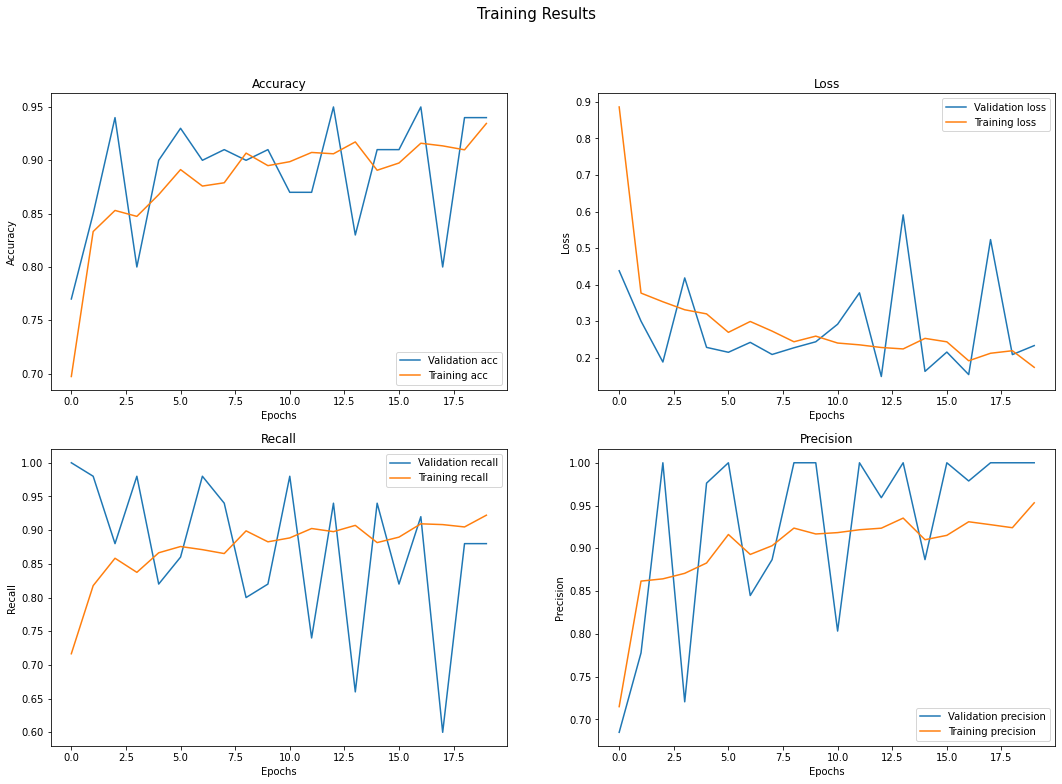

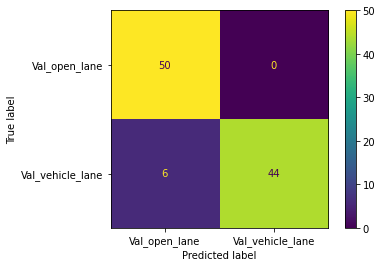

In [29]:
visualize_results(vgg_history, vgg_model, vgg_train_gen, vgg_val_gen)

This model was one of the best in general accuracy and especially with precision. Judging from the loss and other metrics curves above, it's possible that further training (more epochs) would improve the model as well, but that also leads to concerns about overfitting. At this point further training would be recommended only with additional data.

### Final Evaluation

The model is evaluated against the holdout `test` set, as well as inspected using Lime.

In [30]:
testgen = ImageDataGenerator(rescale=1./255).flow_from_directory('input_images/test', class_mode='binary', shuffle=False)

Found 100 images belonging to 2 classes.


In [31]:
vgg_model.evaluate(testgen)

4/4 [==============================] - 11s 3s/step - loss: 0.2078 - acc: 0.9100 - recall_3: 0.9000 - precision_3: 0.9184


[0.207752987742424, 0.9100000262260437, 0.8999999761581421, 0.918367326259613]

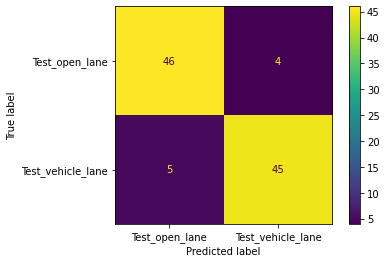

In [32]:
y_val_preds = (vgg_model.predict(testgen) > 0.5).astype('int32')
ConfusionMatrixDisplay(confusion_matrix(testgen.labels, y_val_preds),
                       display_labels=['Test_open_lane', 'Test_vehicle_lane']).plot();

The scores have dropped in comparison to training and validation, but this is to be expected. Even so, the model has maintained accuracy and precision over 90% on unseen data.

Although this model is chosen as the best one for this task so far based solely on metrics, explorations with Lime yield inconsistent results.

In [33]:
datagen = ImageDataGenerator(rescale=1./255)
lime_gen = datagen.flow_from_directory('input_images/full_combined', class_mode='binary', shuffle=True, batch_size=1)

Found 1619 images belonging to 2 classes.



Predicted class: [0.]
Actual class: 0.0


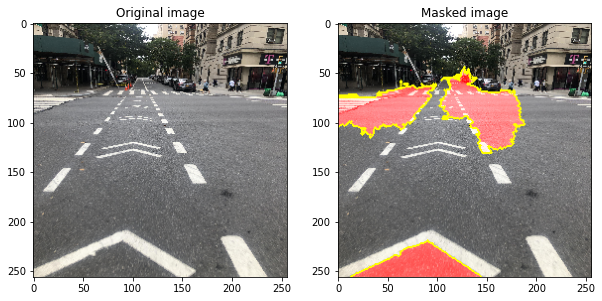

In [34]:
show_explanation(lime_gen, vgg_model)

The image is correctly predicted, but the colors seem to be reversed somehow. The areas marked out by Lime do in fact cover important features that would assist in a correct prediction (the converging bike lanes in the non-target class, e.g.), but are marked in red rather than green.

Further images yield similarly inconsistent results:


Predicted class: [1.]
Actual class: 1.0


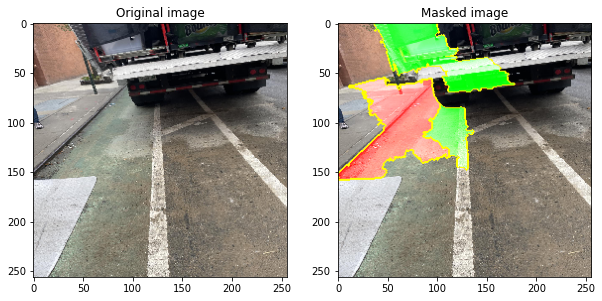


Predicted class: [0.]
Actual class: 1.0


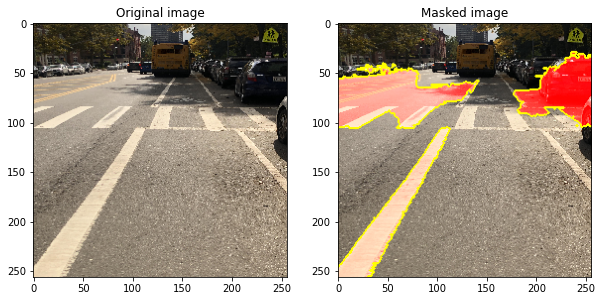


Predicted class: [1.]
Actual class: 1.0


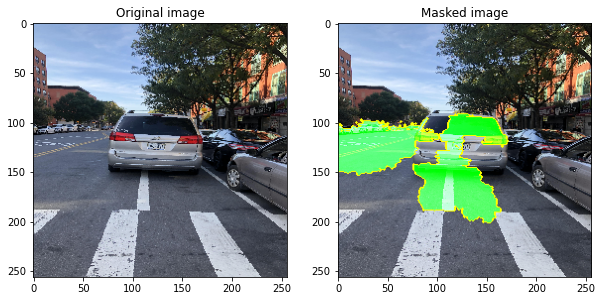


Predicted class: [0.]
Actual class: 0.0


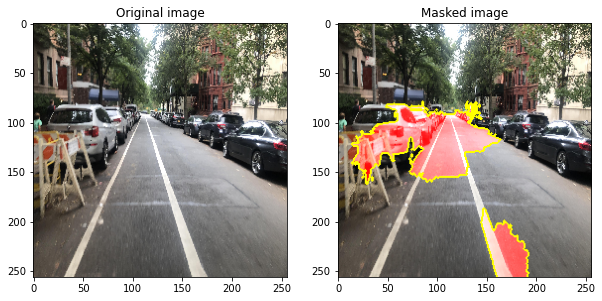


Predicted class: [1.]
Actual class: 1.0


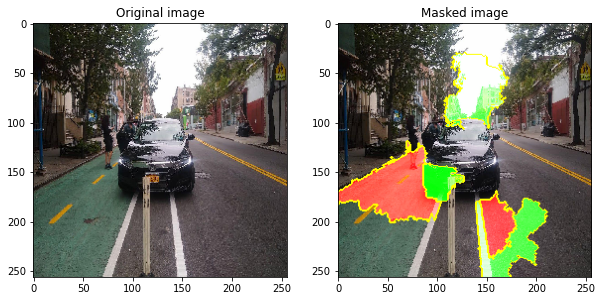

In [35]:
for _ in range(5):
    show_explanation(lime_gen, vgg_model)

Explorations with other `ImageDataGenerator` or new Lime explainer instances were unable to reveal the source of this discrepancy. In other words, it's not totally clear what's going on. For now, it's unclear if the model is making accurate predictions despite the evidence identified in the image, or if Lime is simply struggling to accurately identify pro/con areas with such a large, complex model. 

Nevertheless, the model mostly identifies featuers that are actually important features in the images. With that evidence, as well as its good metrics, this model still stands as the best available one so far for the task of identifying images of vehicles obstructing bike lanes.

### Nightime Images

Although all the images used in training and validation were daytime, there are some nighttime images that were set aside and saved. These images are similar, yet do contain new consistent features such as vehicle lights and often the lanes are more difficult to make out.Let's see how the model does on these images, which contain many similarities

In [36]:
# Directories
night_dir = 'other_images/unused_images/night'
night_open_dir = os.path.join(night_dir, 'open_bike_lane')
night_vehicle_dir = os.path.join(night_dir, 'vehicle_bike_lane')

# Read files in as images
night_open_images = get_images(night_open_dir, num_images=5)
night_vehicle_images = get_images(night_vehicle_dir, num_images=5)

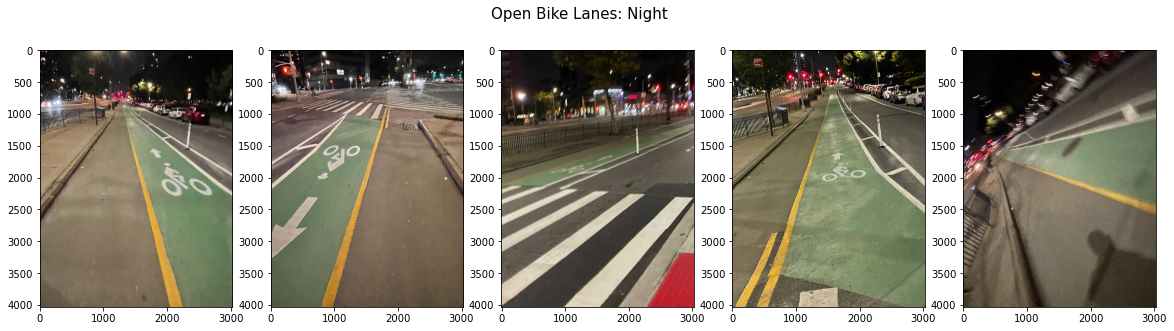

In [37]:
# Images of open bike lanes
# Thanks to Seth Kaufman (https://github.com/SethKauf) for providing these images
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(night_open_images[i]) # See some new ones
fig.suptitle('Open Bike Lanes: Night', fontsize=15)
fig.tight_layout;

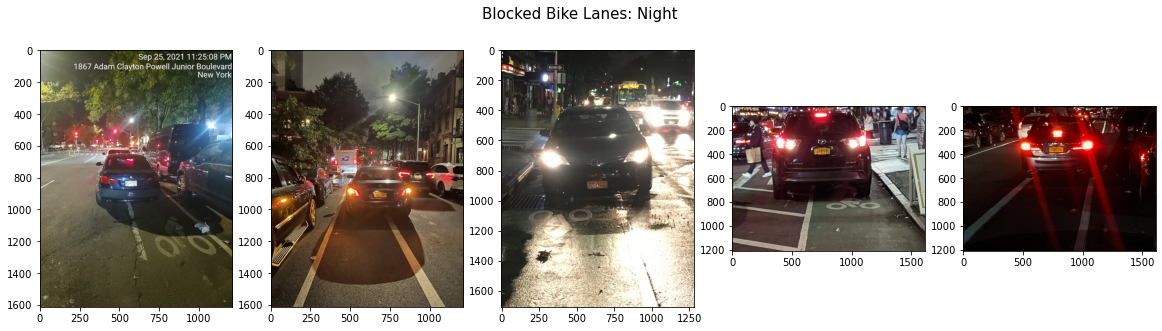

In [38]:
# Images of blocked bike lanes
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(night_vehicle_images[i])
fig.suptitle('Blocked Bike Lanes: Night', fontsize=15)
fig.tight_layout;

There are some issues with these images, such as most of the images being of protected bike lanes with green paint, plus one of the target images still has a timestamp. But let's just see how the model does.

In [39]:
night_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(night_dir, class_mode='binary', shuffle=False)

Found 154 images belonging to 2 classes.


In [40]:
vgg_model.evaluate(night_gen)

5/5 [==============================] - 20s 4s/step - loss: 0.3383 - acc: 0.8312 - recall_3: 0.8333 - precision_3: 0.9746


[0.33831098675727844,
 0.8311688303947449,
 0.8333333134651184,
 0.9745762944221497]

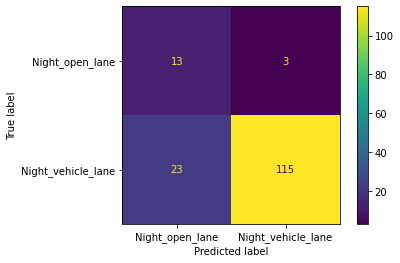

In [41]:
y_val_preds = (vgg_model.predict(night_gen) > 0.5).astype('int32')
ConfusionMatrixDisplay(confusion_matrix(night_gen.labels, y_val_preds),
                       display_labels=['Night_open_lane', 'Night_vehicle_lane']).plot();

Although overall accuracy dropped by almost 10 percentage points, while precision remained high. The class balance in this dataset is also very different from the original dataset, with a strong bias toward the target class, but the model was largely able to recognize vehicles in bike lanes at night and only predicted 3 false positives! 

This suggests that the final VGG-16-based model is particularly adept at spotting vehicles in bike lanes. I suspect that it was a bit thrown by the differences in the bike lane images compared to the general training set, which contained far fewer bike lanes with such vivid green paint fill. I also think that, especially for a model pre-trained on millions of real images, including several classes of vehicles, it will always be easier to recognize the presence of an object in an image rather than its absence. 

Given that one of the measures of success for this project was minimal false positives, these metrics show good evidence for the model to be deployed at night as well as during the day, which it was trained to do. These preliminary results support the case for the generalizability and use of this model as a real, well founded step toward automating bike lane enforcement.

| <img src="readme_images/cab_in_lane.png" alt="yet another cab in a bike lane" width="600"/> | 
|:--:| 
| *A T&LC Vehicle demonstrates why NYC's protected bike lanes need more protection.* |

## Conclusion

Ultimately, the biggest weakness of this project lies in the small size of the dataset. The best way to improve the model's success would be by increasing the size of the dataset to at least 1,000 images per class, if not more, and to add in nighttime images in order to meet the DOT's request that any system be able to operate 24 hours a day. However, the results of this project show a good proof of concept and demonstrates the feasibility of a model that could be used as part of an automated enforcement system to hold drivers accountable for parking their cars in bike lines.

### Recommendations

New York City needs automated bike lane enforcement. The bike lanes are too often treated as free parking for the city's drivers, especially by delivery vehicles, taxis, and police vehicles. This causes dangerous conditions for the ever-increasing number of cyclists on the streets who depend on bike lanes to provide a safer travel corridor, free from traffic. When vehicles are stopped in the bike lane, it forces cyclists to merge into traffic and weave around cars, putting them at risk of fatal injury. Automated enforcement would increase the efficiency and consistenty of ticketing, as well as reduce the need for police to physically engage with drivers. This would save time and human resources, and likely save money as well. 

A great start would be simple stationary cameras, similar to current speeding or red-light cameras. Pointing them down bike lanes on longer, straight streets that are largely free from other obstructions would yield the greatest coverage area. Historic data from Reported could be used to identify and locate especially problematic areas in which bike lanes are consistently clogged. (I can think of a half a dozen locations around the city that have bike lanes I have never been able to actually ride down due to parked vehicles blocking the lanes.)

This is a manageable, if not preventable issue. The Department of Transportation reported that installing the ABLE system on bus lines increased bus route speeds and ridership; they are working to expand the system to cover over 85% of all NYC bus routes. Creating an analogous system for bike lanes would increase safety for bike commuters and anyone else who cycles in the city.

### Next Steps

To improve the model, the best and most important next step is to collect more data, including nighttime images. Beyond that, there are several possible avenues to take this:
 - Identify additional classes, including images with cyclists, motorbikes, or other types of vehicles
 - Move to object *detection* rather than just image classification to identify and locate vehicles in the image
 - Incorporate Automatic License Plate Recognition (APLR) for automated ticketing and look into options for connecting for existing enforcement systems, like ABLE or red light/speed cameras in the city
 - Connect my model to the Reported app to assist in its development

All of these options will contribute to making NYC's streets safer for cyclists.

| <img src="readme_images/unobstructed.png" alt="unobstructed bike lane" width="600"/> | 
|:--:| 
| *The beauty and peace of an unobstructed bike lane* |